In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.gridspec import GridSpec
import seaborn as sns

# import data_clean_utils
from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot
import plotly.express as px
import timeit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import DataConversionWarning


warnings.filterwarnings("ignore")

# importlib.reload(data_clean_script)     # reload

In [2]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [3]:
from sklearn import set_config

set_config(transform_output="pandas")

In [4]:
original_df = pd.read_csv("../data/raw/train.csv")

import sys
import importlib

sys.path.append("../data/files_/")
import data_clean_script

# importlib.reload(data_clean_script)

In [5]:
df = data_clean_script.perform_data_cleaning(original_df)

In [6]:
df.shape

(45502, 19)

In [7]:
df.sample(6)

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
32368,38.0,4.6,stormy,low,1,drinks,scooter,0.0,no,urban,25,SUR,3,monday,0,15.0,morning,3.040691,short
6421,37.0,5.0,stormy,medium,0,drinks,motorcycle,1.0,no,urban,25,HYD,3,friday,0,5.0,afternoon,6.147195,medium
42358,NaN,NaN,NaN,NaN,3,buffet,scooter,1.0,no,metropolitian,18,VAD,4,sunday,1,NaN,NaN,3.029525,short
33805,38.0,4.4,sandstorms,jam,1,buffet,motorcycle,1.0,no,metropolitian,34,AGR,2,monday,0,15.0,night,NaN,NaN
41471,24.0,4.6,stormy,high,2,drinks,motorcycle,0.0,no,metropolitian,14,INDO,3,monday,0,5.0,afternoon,6.051109,medium
44907,37.0,4.9,windy,low,0,snack,motorcycle,1.0,no,metropolitian,28,BANG,3,tuesday,0,10.0,night,17.076725,very_long


In [8]:
df.columns.tolist()

['age',
 'ratings',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'time_taken',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'pickup_time_minutes',
 'order_time_of_day',
 'distance',
 'distance_type']

In [9]:
df.drop(
    columns={"city_name", "order_day_of_week", "order_month"}, axis=1, inplace=True
)  # contains just two months data -- may lead to overfit

In [10]:
df.shape

(45502, 16)

In [11]:
df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

# Exp - 1 drop missing


<Axes: >

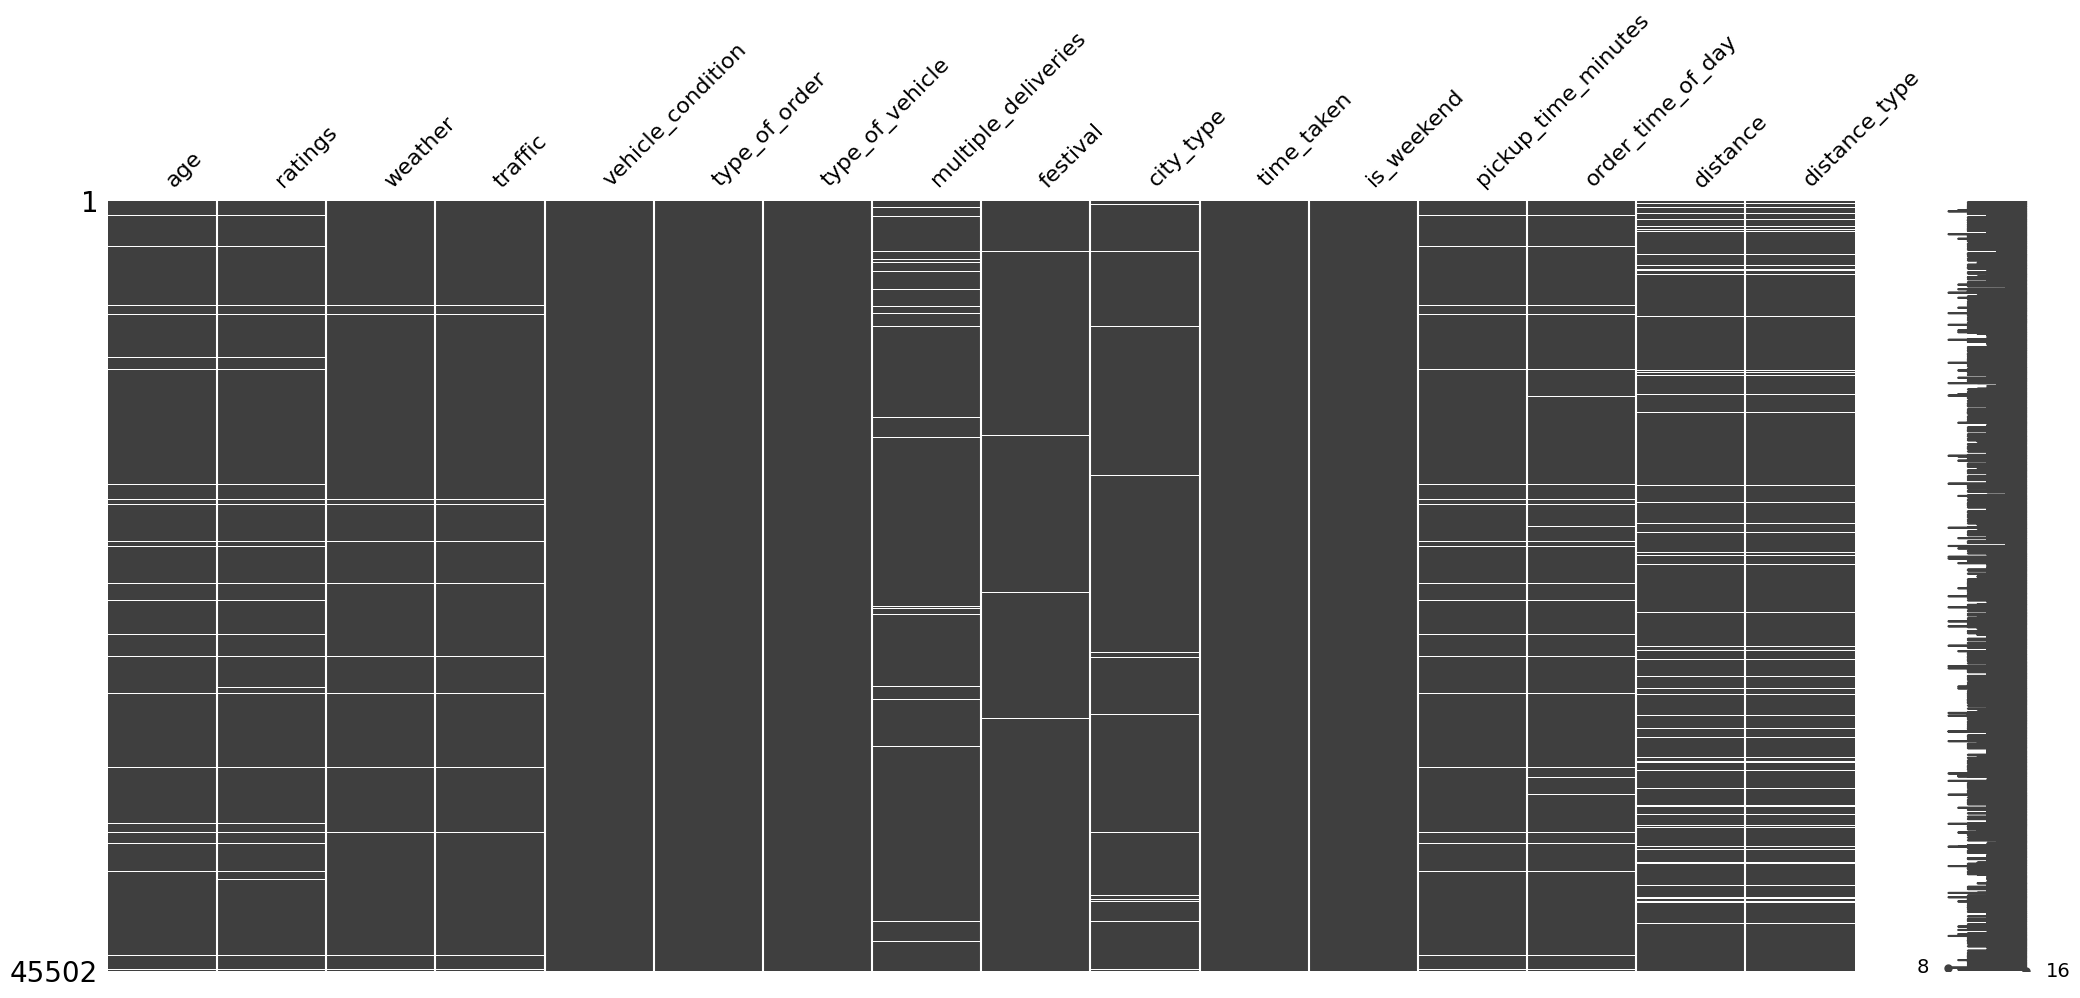

In [13]:
msno.matrix(df)

In [14]:
# Mnar

In [15]:
import mlflow

In [16]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [17]:
mlflow.set_experiment("EXP-1  keep vs impute misisng values")

<Experiment: artifact_location='mlflow-artifacts:/49a29b2d29f64da7927eeaecdff19c67', creation_time=1751014708140, experiment_id='0', last_update_time=1751014708140, lifecycle_stage='active', name='EXP-1  keep vs impute misisng values', tags={}>

In [18]:
temp_df = df.copy().dropna()

In [19]:
X = temp_df.drop(columns="time_taken", axis=1)
y = temp_df["time_taken"]

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [22]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 8720 to 19002
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  30156 non-null  float64 
 1   ratings              30156 non-null  float64 
 2   weather              30156 non-null  object  
 3   traffic              30156 non-null  object  
 4   vehicle_condition    30156 non-null  int64   
 5   type_of_order        30156 non-null  object  
 6   type_of_vehicle      30156 non-null  object  
 7   multiple_deliveries  30156 non-null  float64 
 8   festival             30156 non-null  object  
 9   city_type            30156 non-null  object  
 10  is_weekend           30156 non-null  int64   
 11  pickup_time_minutes  30156 non-null  float64 
 12  order_time_of_day    30156 non-null  category
 13  distance             30156 non-null  float64 
 14  distance_type        30156 non-null  category
dtypes: category(2), float

## Preprocessing


In [23]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,3
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [25]:
xtrain_transformed = preprocessor.fit_transform(xtrain)
xtest_transformed = preprocessor.transform(xtest)

In [26]:
xtrain.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
8720,29.0,3.9,sunny,jam,0,drinks,motorcycle,2.0,no,semi-urban,0,15.0,night,9.348069,medium
25245,39.0,4.4,sandstorms,medium,0,meal,motorcycle,1.0,no,metropolitian,1,5.0,afternoon,4.469606,short
34118,29.0,4.5,sunny,high,1,buffet,motorcycle,0.0,no,urban,0,10.0,morning,1.513073,short
26036,39.0,4.8,sandstorms,low,0,meal,motorcycle,1.0,no,metropolitian,1,15.0,night,10.445118,long
37194,30.0,4.4,windy,medium,1,buffet,scooter,1.0,no,metropolitian,1,10.0,afternoon,6.217834,medium


In [27]:
pt = PowerTransformer()
ytrain_transformed = pt.fit_transform(ytrain.values.reshape(-1, 1))
ytest_transformed = pt.transform(ytest.values.reshape(-1, 1))
pt.lambdas_

array([0.32446095])

In [28]:
rf = RandomForestRegressor()
rf.fit(xtrain_transformed, ytrain_transformed)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
ytrain_pred = rf.predict(xtrain_transformed)
ytest_pred = rf.predict(xtest_transformed)

In [30]:
ytrain_pred = pt.inverse_transform(ytrain_pred.reshape(-1, 1))
ytest_pred = pt.inverse_transform(ytest_pred.reshape(-1, 1))

In [31]:
print("MAE: Train error: ", mean_absolute_error(ytrain, ytrain_pred), "minutes")
print("MAE: Test error: ", mean_absolute_error(ytest, ytest_pred), "minutes")
print("-" * 5, "\nr2: Train score: ", r2_score(ytrain, ytrain_pred))
print("r2: Test score: ", r2_score(ytest, ytest_pred))

MAE: Train error:  1.1552220221296474 minutes
MAE: Test error:  3.090184215925198 minutes
----- 
r2: Train score:  0.9754815242420258
r2: Test score:  0.8265995559514268


In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf, xtrain_transformed, ytrain_transformed, cv=5, scoring="r2", n_jobs=4
)

In [33]:
scores

array([0.80841145, 0.81033051, 0.81146362, 0.809646  , 0.81145013])

In [34]:
scores.mean()

np.float64(0.8102603409678515)

In [35]:
# scores.mean() np.float64(0.8266552255635975) without PowerTransformer

<Axes: >

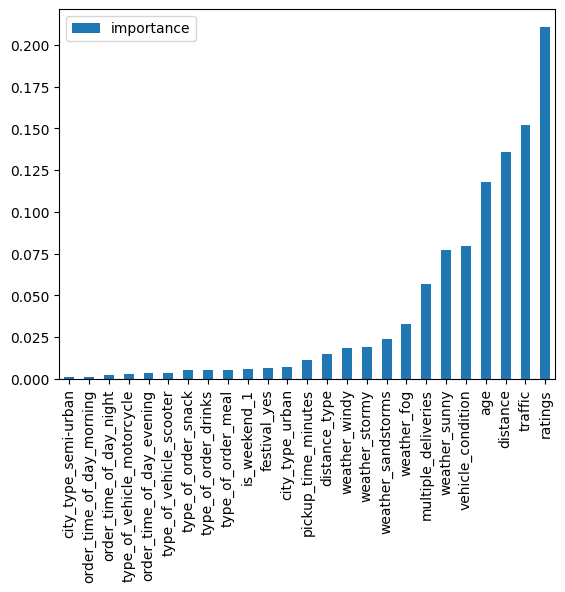

In [36]:
pd.DataFrame(
    rf.feature_importances_, index=xtrain_transformed.columns, columns=["importance"]
).sort_values(by="importance").plot(kind="bar")

In [37]:
pd.DataFrame(
    rf.feature_importances_, index=xtrain_transformed.columns, columns=["importance"]
).sort_values(by="importance")

,importance
city_type_semi-urban,0.000789
order_time_of_day_morning,0.001122
order_time_of_day_night,0.002232
type_of_vehicle_motorcycle,0.003135
order_time_of_day_evening,0.003256
type_of_vehicle_scooter,0.003456
type_of_order_snack,0.005286
type_of_order_drinks,0.005323
type_of_order_meal,0.005499
is_weekend_1,0.005764


In [38]:
# log Experiment
import mlflow.experiments


with mlflow.start_run(run_name="Missing values dropped"):
    mlflow.log_param("experiment_type", "Missing values dropped ")

    # log model param
    mlflow.log_params(rf.get_params())

    # log metrices
    mlflow.log_metric("training error", mean_absolute_error(ytrain, ytrain_pred))
    mlflow.log_metric("test error : ", mean_absolute_error(ytest, ytest_pred))
    mlflow.log_metric("Train r2_score: ", r2_score(ytrain, ytrain_pred))
    mlflow.log_metric("Test r2_score: ", r2_score(ytest, ytest_pred))

🏃 View run Missing values dropped at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0/runs/5af530a4a8fa475fa4dc5d6c247290e6
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0


In [39]:
from sklearn.feature_selection import RFECV

In [ ]:
# feature selection using rfecv - Recursive Feature Elimination with Cross-Validation.

rfecv = RFECV(estimator=rf, step=10, cv=5, scoring="r2", n_jobs=3, verbose=2)

In [43]:

rfecv.fit(xtrain_transformed, ytrain_transformed.values.ravel())

Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.


,estimator,RandomForestRegressor()
,step,10
,min_features_to_select,1
,cv,5
,scoring,'r2'
,verbose,2
,n_jobs,-1
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None


In [44]:
# list of selected features

rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_motorcycle',
       'type_of_vehicle_scooter', 'festival_yes', 'city_type_semi-urban',
       'city_type_urban', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night',
       'is_weekend_1', 'traffic', 'distance_type', 'vehicle_condition',
       'multiple_deliveries'], dtype=object)

In [45]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(xtrain_transformed), ytrain_transformed.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
y_pred_train = rf.predict(rfecv.transform(xtrain_transformed))
y_pred_test = rf.predict(rfecv.transform(xtest_transformed))

In [47]:

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [48]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(ytrain,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(ytest,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.08 minutes


In [49]:
print(f"The train r2 score is {r2_score(ytrain,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(ytest,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [ ]:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf,
    rfecv.transform(xtrain_transformed),
    ytrain_transformed.values.ravel(),
    cv=5,
    scoring="r2",
    n_jobs=4,
)

scores

array([0.80792873, 0.8104645 , 0.81083402, 0.8098679 , 0.81147484])

In [51]:

scores.mean()

np.float64(0.8101139983779083)

In [52]:
rf.feature_importances_

array([0.11898949, 0.21142081, 0.01143986, 0.13821793, 0.03302608,
       0.024282  , 0.01977332, 0.07986708, 0.0180044 , 0.00533098,
       0.00552188, 0.00531216, 0.00312602, 0.00341061, 0.00627684,
       0.00075957, 0.00744155, 0.00326467, 0.00115457, 0.00225979,
       0.00579643, 0.15170631, 0.01352504, 0.08165816, 0.04843445])

<Axes: >

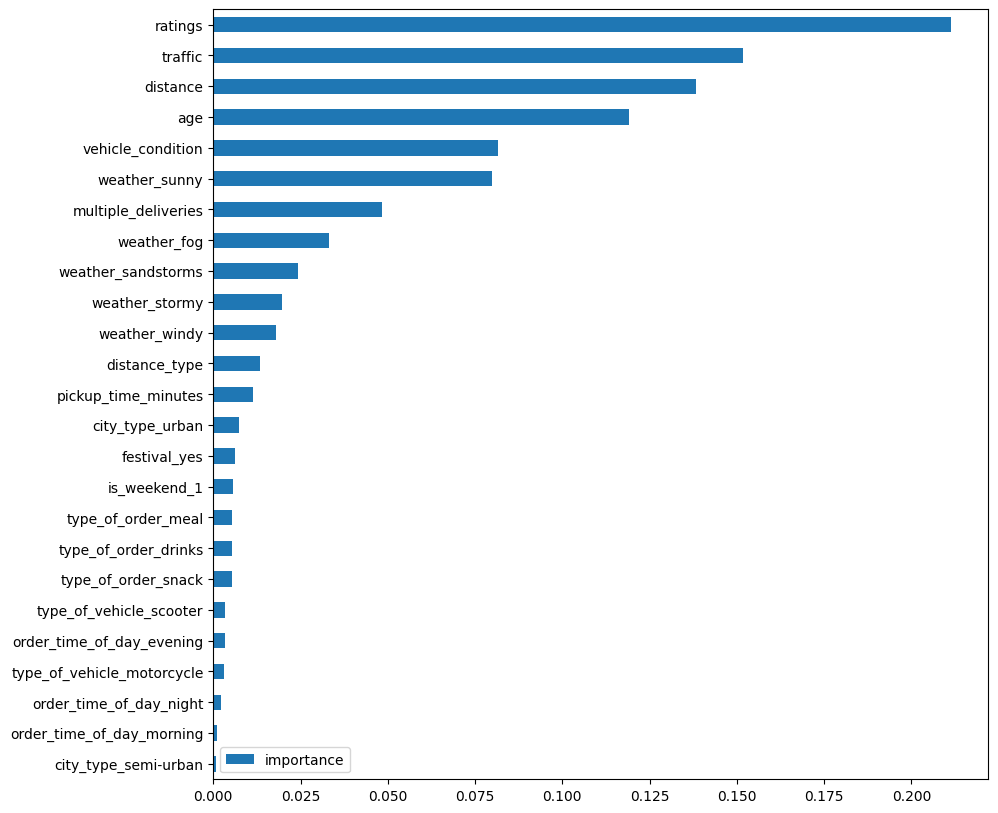

In [53]:

(
    pd.DataFrame(
        rf.feature_importances_,
        index=rfecv.transform(xtrain_transformed).columns,
        columns=["importance"],
    )
    .sort_values(by="importance")
    .plot(kind="barh", figsize=(10, 10))
)

# Impute Missing values


In [54]:
temp_df = df.copy()

In [55]:

X = temp_df.drop(columns="time_taken")
y = temp_df["time_taken"]

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45589,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,0,15.0,evening,NaN,NaN
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
print("The size of train data is", X_train.shape)
print("The shape of test data is", X_test.shape)

The size of train data is (36401, 15)
The shape of test data is (9101, 15)


In [58]:
# missing values in train data

X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [59]:
pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_pt = pt.transform(y_test.values.reshape(-1, 1))

In [60]:
missing_cols = temp_df.isna().sum().index
missing_cols
missing_cols = df.isna().any(axis=0).loc[lambda x: x].index
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [61]:
(X_train.isna().any(axis=1).mean().round(2) * 100)

np.float64(17.0)

# Imputation Pipeline


In [62]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'order_time_of_day',
 'is_weekend']

In [63]:
X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [64]:
features_to_fill_mode = ["multiple_deliveries", "festival", "city_type"]
features_to_fill_missing = [
    col for col in nominal_cat_cols if col not in features_to_fill_mode
]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'order_time_of_day',
 'is_weekend']

In [ ]:

simple_imputer = ColumnTransformer(
    transformers=[
        (
            "mode_imputer",
            SimpleImputer(strategy="most_frequent"),
            features_to_fill_mode,
        ),
        (
            "missing_imputer",
            SimpleImputer(strategy="constant", fill_value="missing"),
            features_to_fill_missing,
        ),
    ],
    remainder="passthrough",
    n_jobs=4,
    verbose_feature_names_out=False,
)

simple_imputer

,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [66]:
simple_imputer.fit_transform(X_train)

,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,order_time_of_day,is_weekend,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
11047,1.0,no,metropolitian,windy,snack,electric_scooter,evening,0,26.0,4.7,jam,2,10.0,9.177684,medium
15692,1.0,no,metropolitian,windy,drinks,motorcycle,afternoon,0,21.0,4.9,medium,2,5.0,6.081536,medium
14499,1.0,no,metropolitian,stormy,meal,scooter,missing,1,NaN,NaN,low,2,NaN,1.554563,short
29258,1.0,no,metropolitian,windy,buffet,motorcycle,evening,0,32.0,4.7,medium,0,15.0,20.852271,very_long
22554,0.0,no,urban,sandstorms,meal,scooter,night,0,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.0,no,metropolitian,sandstorms,meal,scooter,evening,0,29.0,4.7,jam,2,5.0,12.464367,long
44821,0.0,no,urban,cloudy,buffet,motorcycle,morning,0,36.0,4.8,low,0,10.0,1.520432,short
38234,0.0,no,metropolitian,fog,buffet,scooter,evening,0,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,windy,meal,scooter,afternoon,1,25.0,4.9,medium,2,5.0,7.760938,medium


In [67]:
simple_imputer.fit_transform(X_train).isna().sum()

multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
order_time_of_day         0
is_weekend                0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [68]:

knn_imputer = KNNImputer(n_neighbors=5)

In [69]:

num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "is_weekend",
    "order_time_of_day",
]

ordinal_cat_cols = ["traffic", "distance_type"]

In [70]:
#  order for ordinal encoding

traffic_order = ["low", "medium", "high", "jam"]

distance_type_order = ["short", "medium", "long", "very_long"]

In [71]:

for col in ordinal_cat_cols:
    print(col, X_train[col].unique())

traffic ['jam' 'medium' 'low' 'high' nan]
distance_type ['medium', 'short', 'very_long', 'long', NaN]
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(
                categories=[traffic_order, distance_type_order],
                encoded_missing_value=-999,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            ),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=4,
    verbose_feature_names_out=False,
)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [73]:
preprocessor.fit_transform(X_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,city_type_nan,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11047,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15692,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14499,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29258,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22554,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44821,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38234,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [74]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser: ser.ge(1)]

age                    1470
ratings                1510
pickup_time_minutes    1298
distance               2931
multiple_deliveries     795
dtype: int64

In [75]:

processing_pipeline = Pipeline(
    steps=[
        ("simple_imputer", simple_imputer),
        ("preprocess", preprocessor),
        ("knn_imputer", knn_imputer),
    ]
)

processing_pipeline

,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [76]:
model_pipe = Pipeline(steps=[("preprocessing", processing_pipeline), ("model", rf)])

model_pipe

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [77]:

model_pipe.fit(X_train, y_train_pt.values.ravel())

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [78]:
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [79]:
# inverse power transform 

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [80]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.31 minutes


In [81]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.80


In [82]:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model_pipe, X_train, y_train_pt.values.ravel(), cv=5, scoring="r2", n_jobs=4
)

scores

array([0.78039992, 0.78440744, 0.78294032, 0.77693062, 0.78075432])

In [83]:

scores.mean()

np.float64(0.7810865235366101)

NO significant improvement so imputation is not giving good results

In [85]:
with mlflow.start_run(run_name=" Impute missing values "):
#log experiment 

    mlflow.log_param("experiment_type","Impute missing values ")
    mlflow.log_params(rf.get_params())

    # log metrics 

    mlflow.log_metric("training error", mean_absolute_error(y_train, y_pred_train_org))
    mlflow.log_metric("test error : ", mean_absolute_error(y_test, y_pred_test_org))
    mlflow.log_metric("Train r2_score: ", r2_score(y_train, y_pred_train_org))
    mlflow.log_metric("Test r2_score: ", r2_score(y_test, y_pred_test_org))
    mlflow.log_metric("cross_val: ",scores.mean())

🏃 View run  Impute missing values  at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0/runs/ea4d730641714b74ad8e5b10655f05f4
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0
